In [1]:
import os
import collections

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.load import load_dataset
from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
input_path = os.path.join(os.getcwd(), 'data/ncbi/dataset.csv')
alphabet = ['A', 'T', 'G', 'C']

In [4]:
dataset_df = load_dataset(input_path, alphabet, secondary=False)
dataset_df.shape

(59295, 13)

## Method

- Generate balanced classes with a greater temperature granularity (say about 8-10)
- Select the same number of species & same number of genes in all classes

In [5]:
y = dataset_df['temperature'].values.astype(np.float64)

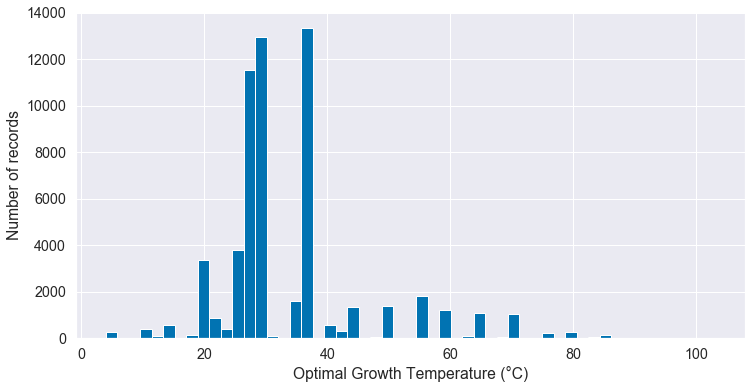

In [6]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(y, bins=len(np.unique(y)));
ax.set_xlabel('Optimal Growth Temperature (°C)');
ax.set_ylabel('Number of records');

In [64]:
def bin_data(y, bins):
    output = []
    counts = collections.defaultdict(int)
    bucket_to_species = collections.defaultdict(set)
    specie_to_bin = dict()
    for i, yi in enumerate(y):
        for j, bin_ in enumerate(bins):
            if yi >= bin_[0] and yi < bin_[1]:
                output.append(j)
                counts[j] += 1
                specie_name = dataset_df.iloc[i]['specie_name']
                if specie_name in specie_to_bin and specie_to_bin[specie_name] != j:
                    print(specie_name, j, specie_to_bin[specie_name])
                    raise ValueError()
                specie_to_bin[specie_name] = j
                bucket_to_species[j].add(specie_name)
                break
                
    for i in range(len(bins)):
        print(bins[i], counts[i])
        
    return np.array(output), bucket_to_species

In [65]:
bins = [
    [4, 25],
    [25, 30],
    [30, 35],
    [35, 40],
    [40, 80],
]
y_binned, bucket_to_species = bin_data(y, bins)
y_binned.shape, len(bins)

[4, 25] 6168
[25, 30] 15357
[30, 35] 13083
[35, 40] 14879
[40, 80] 9274


((58761,), 5)

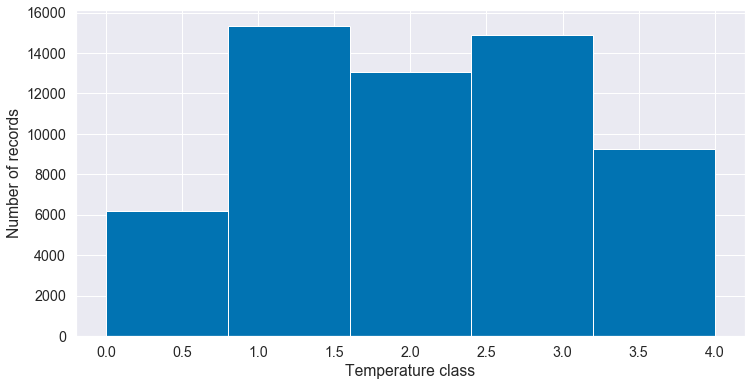

In [66]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(y_binned, bins=len(np.unique(y_binned)));
ax.set_xlabel('Temperature class');
ax.set_ylabel('Number of records');

In [67]:
for k in sorted(bucket_to_species.keys()):
    print(k, len(bucket_to_species[k]))

0 238
1 581
2 503
3 588
4 390


In [68]:
def balanced_species_per_temperature_buckets(species_per_temp_bucket, seed):
    rs = np.random.RandomState(seed)
    
    n_species = np.inf
    buckets = sorted(species_per_temp_bucket.keys())
    for k in buckets:
        n = len(species_per_temp_bucket[k])
        if n < n_species:
            n_species = n
    
    print(f'Species per bucket in balance dataset: {n_species}')
    assert n_species < np.inf
    
    species = []
    for k in buckets:
        species_in_bucket = sorted(species_per_temp_bucket[k])
        
        if len(species_in_bucket) <= n_species:
            species += species_in_bucket
        else:
            species_ = rs.choice(species_in_bucket, size=n_species, replace=False)
            species += sorted(species_.tolist())
            
    assert len(species) == len(buckets) * n_species
    assert len(species) == len(set(species))

    return species

In [69]:
selected_species = balanced_species_per_temperature_buckets(bucket_to_species, seed=444)

Species per bucket in balance dataset: 238


## Split train test sets

In [80]:
def split_train_test_sets(selected_species, test_ratio, seed):
    assert test_ratio > 0 and test_ratio < 1
    
    rs = np.random.RandomState(seed)
    
    n_species = len(selected_species)
    
    test_idx = rs.choice(range(n_species), size=int(test_ratio * n_species), replace=False)
    test_idx_set = set(test_idx.tolist())
    train_idx = np.array([idx for idx in range(n_species) if idx not in test_idx_set])
    
    selected_species_ndarray = np.array(selected_species)
    
    train_set = selected_species_ndarray[train_idx]
    test_set = selected_species_ndarray[test_idx]
    
    assert len(train_set) == len(train_idx)
    assert len(test_set) == len(test_idx)
    assert len(train_set) + len(test_set) == n_species
    
    return train_set, test_set, train_idx, test_idx

In [81]:
train_set, test_set, train_idx, test_idx = split_train_test_sets(selected_species, test_ratio=0.2, seed=444)

In [86]:
len(dataset_df[dataset_df['specie_name'].isin(test_set)])

6068

In [87]:
len(dataset_df[dataset_df['specie_name'].isin(train_set)])

24345

In [90]:
output_train_path = os.path.join(os.getcwd(), 'data/dataset_balanced_train.csv')
output_test_path = os.path.join(os.getcwd(), 'data/dataset_balanced_test.csv')

In [91]:
def export_train_test(dataset_df, train_set, test_set, output_train_path, output_test_path):
    df_train = dataset_df[dataset_df['specie_name'].isin(train_set)].reset_index(drop=True)
    df_test = dataset_df[dataset_df['specie_name'].isin(test_set)].reset_index(drop=True)
    
    df_train.to_csv(output_train_path, index=False)
    df_test.to_csv(output_test_path, index=False)

In [92]:
# export_train_test(dataset_df, train_set, test_set, output_train_path, output_test_path)

In [93]:
df_train = dataset_df[dataset_df['specie_name'].isin(train_set)].reset_index(drop=True)
df_test = dataset_df[dataset_df['specie_name'].isin(test_set)].reset_index(drop=True)

In [94]:
y_train = df_train['temperature'].values.astype(np.float64)
y_test = df_test['temperature'].values.astype(np.float64)

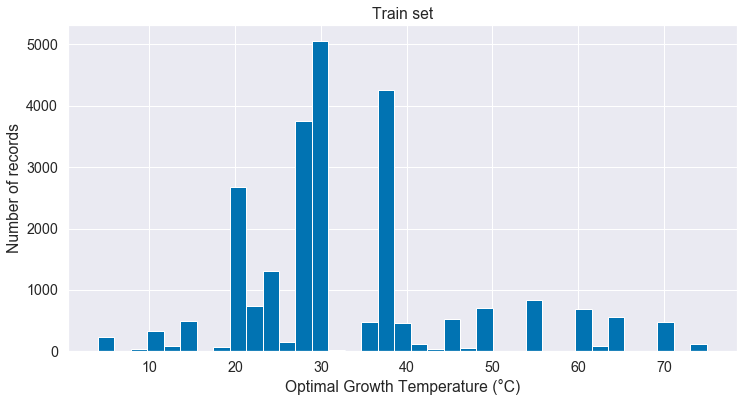

In [95]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(y_train, bins=len(np.unique(y_train)));
ax.set_xlabel('Optimal Growth Temperature (°C)');
ax.set_ylabel('Number of records');
ax.set_title('Train set');

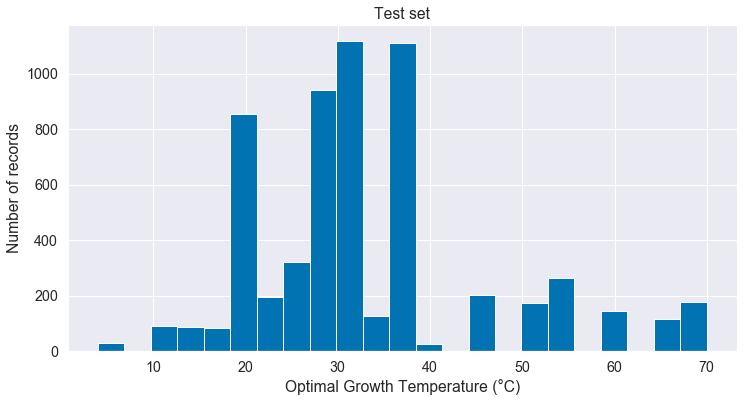

In [96]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(y_test, bins=len(np.unique(y_test)));
ax.set_xlabel('Optimal Growth Temperature (°C)');
ax.set_ylabel('Number of records');
ax.set_title('Test set');